**我们能听到相位吗？**  
本笔记展示了相位变化对声音感知的影响。  
我们先从一个简单的锯齿波开始，然后转到更自然的声音。

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from thinkdsp import decorate

In [2]:
from thinkdsp import SawtoothSignal

signal = SawtoothSignal(freq=500, offset=0)
wave = signal.make_wave(duration=0.5, framerate=40000)
wave.make_audio()

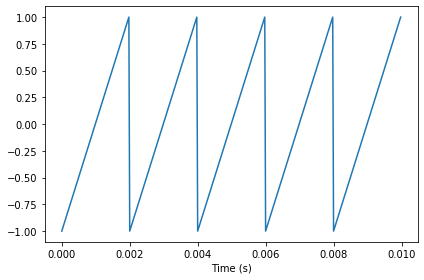

In [3]:
wave.segment(duration=0.01).plot()
decorate(xlabel='Time (s)')

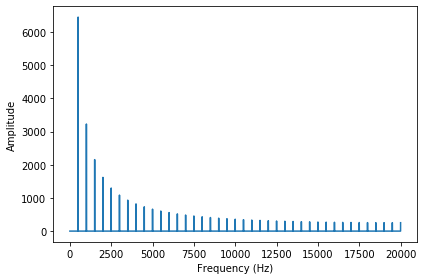

In [4]:
spectrum = wave.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)',
         ylabel='Amplitude')

以下函数绘制频谱的角度部分。

In [5]:
def plot_angle(spectrum, thresh=1):
    angles = spectrum.angles
    angles[spectrum.amps < thresh] = np.nan
    plt.plot(spectrum.fs, angles, 'x')
    decorate(xlabel='Frequency (Hz)', 
             ylabel='Phase (radian)')

在大多数频率下，幅度很小，角度几乎是一个随机数。
因此，如果我们绘制所有角度，那就有点混乱了。

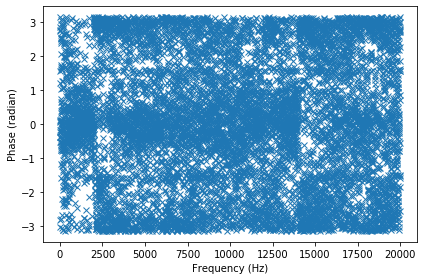

In [6]:
plot_angle(spectrum, thresh=0)

但是，如果仅选择幅度超过阈值的频率，则会看到角度中存在结构。
每个谐波与上一个谐波的偏移量为弧度的一小部分。

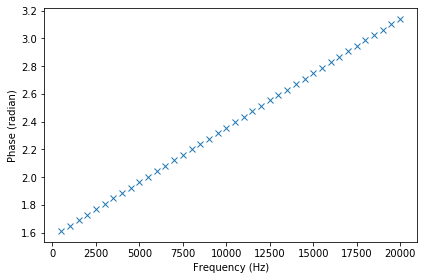

In [7]:
plot_angle(spectrum, thresh=1)

以下函数绘制给定频谱的幅度，角度和波形。

In [8]:
def plot_three(spectrum, thresh=1):
    """Plot amplitude, phase, and waveform.
    
    spectrum: Spectrum object
    thresh: threshold passed to plot_angle
    """
    plt.figure(figsize=(10, 4))
    plt.subplot(1,3,1)
    spectrum.plot()
    plt.subplot(1,3,2)
    plot_angle(spectrum, thresh=thresh)
    plt.subplot(1,3,3)
    wave = spectrum.make_wave()
    wave.unbias()
    wave.normalize()
    wave.segment(duration=0.01).plot()
    display(wave.make_audio())

这样我们就可以可视化未修改的频谱：

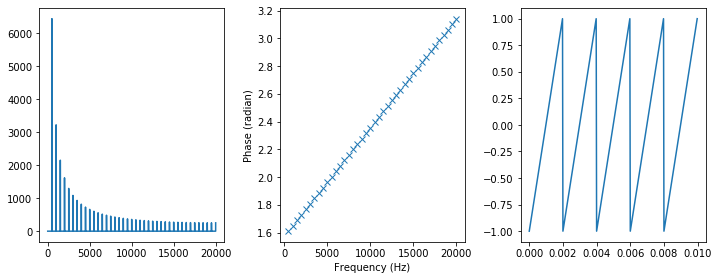

In [9]:
plot_three(spectrum)

现在让我们看看如果将所有角度都设置为零会发生什么。

In [10]:
def zero_angle(spectrum):
    res = spectrum.copy()
    res.hs = res.amps
    return res

幅度没有变化，角度都为零，并且波形看起来非常不同。
但是波浪的声音几乎一样。

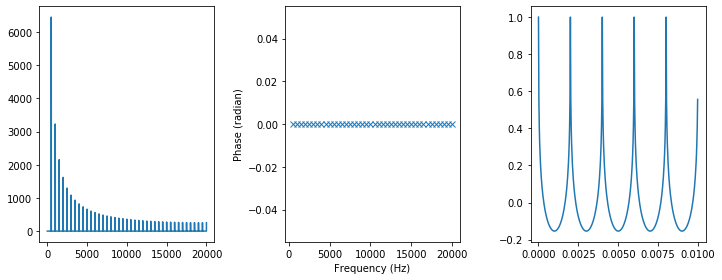

In [11]:
spectrum2 = zero_angle(spectrum)
plot_three(spectrum2)

您可能会注意到音量降低了，但这是由于波浪归一化的原因。
那不是因为相结构的变化。
如果将复数乘以exp(iφ)，则具有将φ添加到角度的效果：

In [12]:
def rotate_angle(spectrum, offset):
    res = spectrum.copy()
    res.hs *= np.exp(1j * offset)
    return res

我们可以在下图中看到效果。
同样，波形不同，但听起来几乎相同。

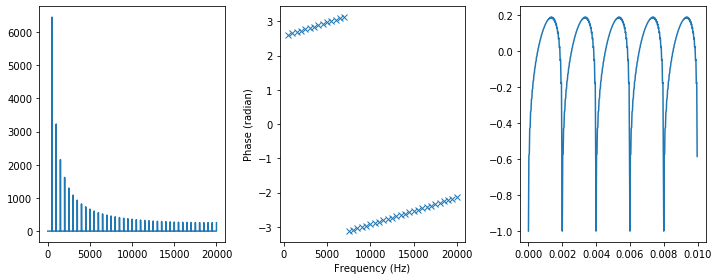

In [13]:
spectrum3 = rotate_angle(spectrum, 1)
plot_three(spectrum3)

最后，让我们看看如果将角度设置为随机值会发生什么。

In [14]:
PI2 = np.pi * 2

def random_angle(spectrum):
    res = spectrum.copy()
    angles = np.random.uniform(0, PI2, len(spectrum))
    res.hs *= np.exp(1j * angles)
    return res

对波形的影响是深远的，但是感知到的声音是相同的。

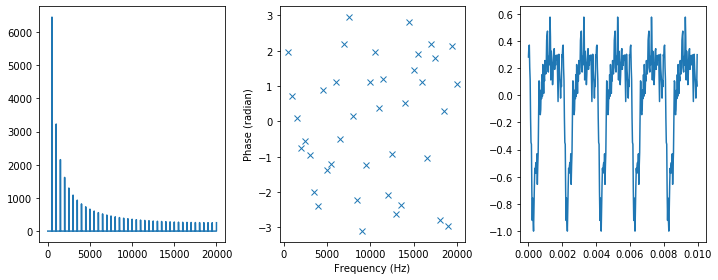

In [15]:
spectrum4 = random_angle(spectrum)
plot_three(spectrum4)

让我们看看自然声音会发生什么。
这是双簧管的录音。

In [16]:
from thinkdsp import read_wave

wave = read_wave('120994__thirsk__120-oboe.wav')
wave.make_audio()

我将选择一个音高恒定的线段。
这是原始的样子。

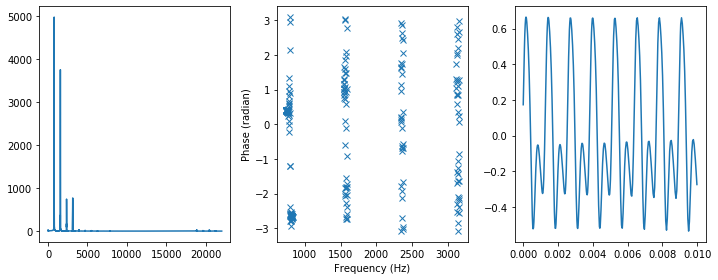

In [17]:
segment = wave.segment(start=0.05, duration=0.9)
spectrum = segment.make_spectrum()
plot_three(spectrum, thresh=50)

所有角度都设置为零。

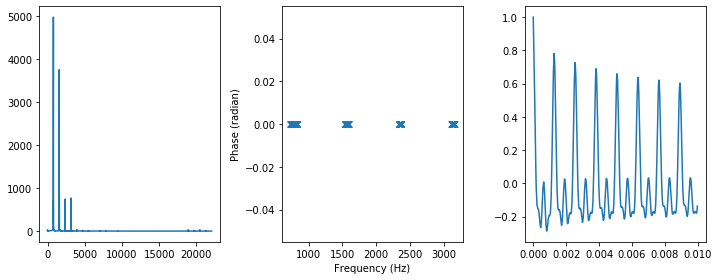

In [18]:
spectrum2 = zero_angle(spectrum)
plot_three(spectrum2, thresh=50)

改变相结构似乎会产生“振铃”效应，音量随时间变化。
在这里，角度旋转了1个弧度。

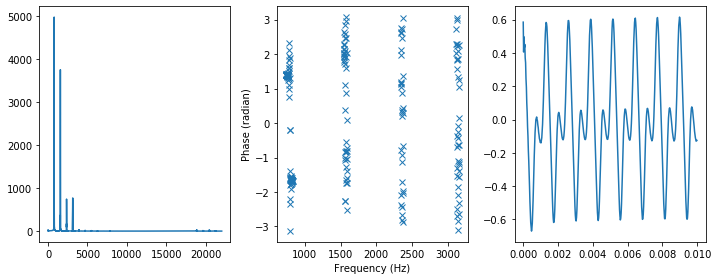

In [19]:
spectrum3 = rotate_angle(spectrum, 1)
plot_three(spectrum3, thresh=50)

旋转角度似乎不会引起振铃。
这里是随机角度。

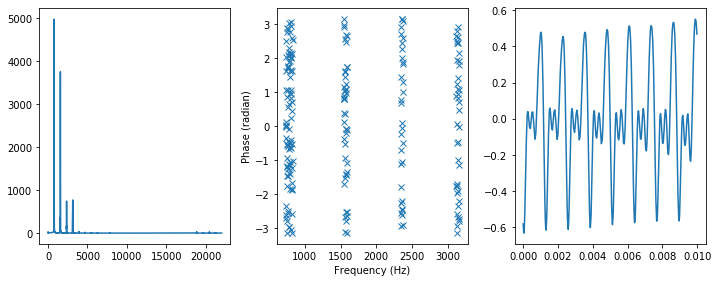

In [20]:
spectrum4 = random_angle(spectrum)
plot_three(spectrum4, thresh=50)

使角度随机化似乎会引起一些振铃，并为声音增添呼吸感。

**让我们用萨克斯管的录音片段来尝试同样的事情。**

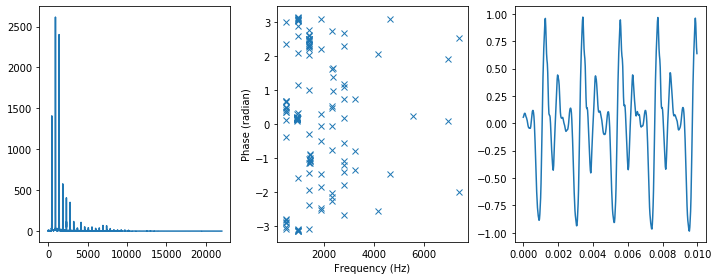

In [21]:
wave = read_wave('100475__iluppai__saxophone-weep.wav')
wave.make_audio()
segment = wave.segment(start=1.9, duration=0.6)
spectrum = segment.make_spectrum()
plot_three(spectrum, thresh=50)

将角度设置为0。

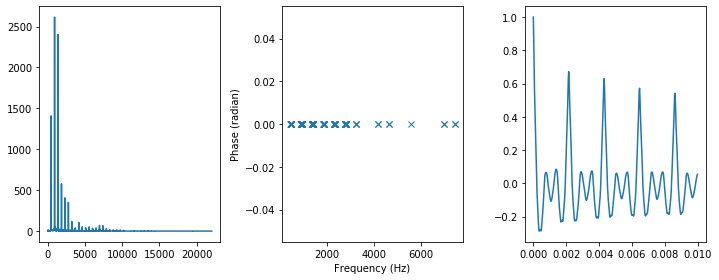

In [22]:
spectrum2 = zero_angle(spectrum)
plot_three(spectrum2, thresh=50)

将角度旋转1个弧度。

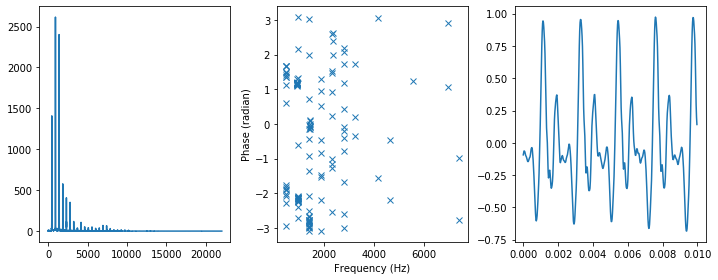

In [23]:
spectrum3 = rotate_angle(spectrum, 1)
plot_three(spectrum3, thresh=50)

随机化角度。

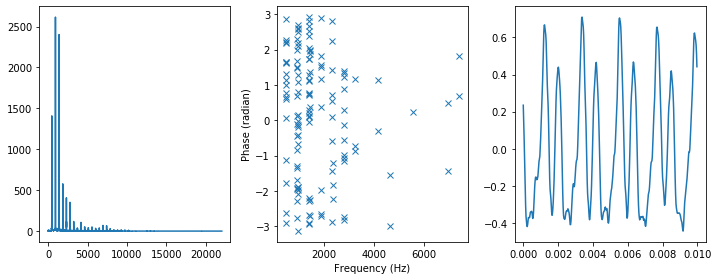

In [24]:
spectrum4 = random_angle(spectrum)
plot_three(spectrum4, thresh=50)

同样，调零似乎会产生振铃，旋转几乎没有效果，而随机化则增加了呼吸效果。
萨克斯风不同于其他声音的一种方式是基本成分不是主要成分。
对于这样的声音，我推测除了频谱分析外，耳朵还使用了类似自相关的功能，并且这种次要分析模式可能对相位结构更敏感。
如果是这样，当根本没有基础时，效果应该更深远。

**萨克斯风缺少基本面**
在筛选出基本要素之后，让我们再运行一次这些步骤。

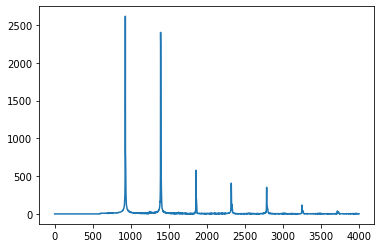

In [25]:
spectrum.high_pass(600)
spectrum.plot(high=4000)

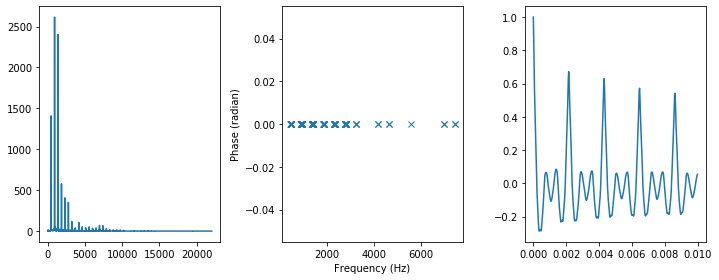

In [26]:
plot_three(spectrum2, thresh=50)

调零

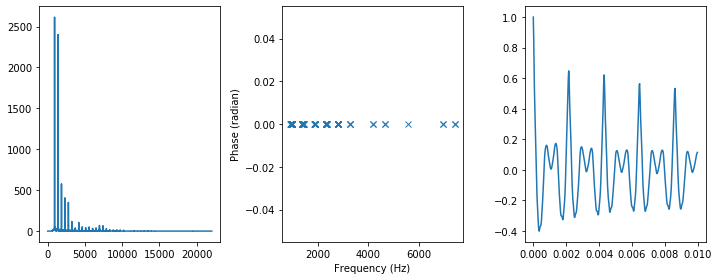

In [27]:
spectrum2 = zero_angle(spectrum)
plot_three(spectrum2, thresh=50)

旋转

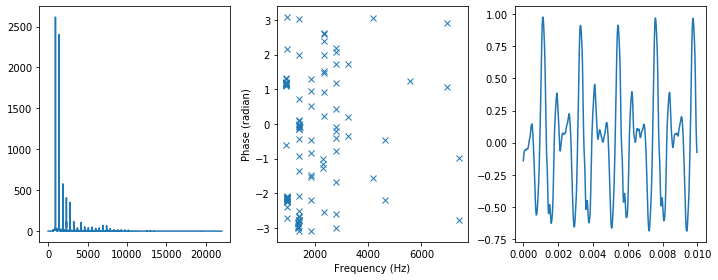

In [28]:
spectrum3 = rotate_angle(spectrum, 1)
plot_three(spectrum3, thresh=50)

随机化

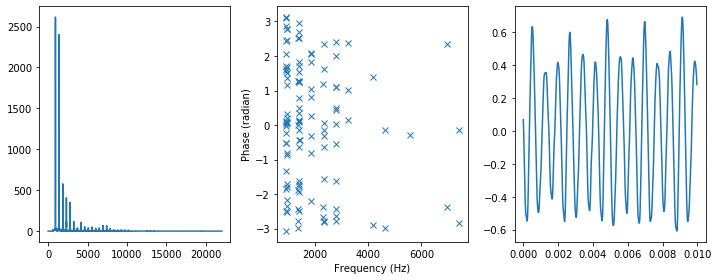

In [29]:
spectrum4 = random_angle(spectrum)
plot_three(spectrum4, thresh=50)

综上所述：
至少对于具有简单谐波结构的声音，似乎我们大多是“相位盲”的。
也就是说，只要谐波结构不变，我们就不会听到相结构的变化。
一个可能的例外是声音在基频处的振幅较低。
在那种情况下，我们可能会使用类似自相关的方法来感知音高，并且暗示此分析可能对相位结构更为敏感。